In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import os

In [3]:
os.makedirs("generated_images", exist_ok=True)


In [4]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator().to(device)
discriminator = Discriminator().to(device)

loss_function = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
epochs = 20

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):

        real_images = real_images.to(device)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        outputs = discriminator(real_images)
        d_loss_real = loss_function(outputs, real_labels)

        z = torch.randn(real_images.size(0), 100).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = loss_function(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        outputs = discriminator(fake_images)
        g_loss = loss_function(outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Save fake images
    save_image(fake_images[:25], f"generated_images/epoch_{epoch+1}.png", nrow=5, normalize=True)


Epoch [1/20] | D Loss: 0.0444 | G Loss: 6.2072
Epoch [2/20] | D Loss: 0.4014 | G Loss: 4.4608
Epoch [3/20] | D Loss: 0.9926 | G Loss: 3.0186
Epoch [4/20] | D Loss: 0.5696 | G Loss: 2.2748
Epoch [5/20] | D Loss: 0.2205 | G Loss: 2.9217
Epoch [6/20] | D Loss: 0.6509 | G Loss: 2.8685
Epoch [7/20] | D Loss: 0.1956 | G Loss: 4.2784
Epoch [8/20] | D Loss: 1.3711 | G Loss: 5.5568
Epoch [9/20] | D Loss: 0.8822 | G Loss: 5.0368
Epoch [10/20] | D Loss: 0.0629 | G Loss: 6.4485
Epoch [11/20] | D Loss: 0.3892 | G Loss: 4.3650
Epoch [12/20] | D Loss: 0.7078 | G Loss: 5.9337
Epoch [13/20] | D Loss: 0.1915 | G Loss: 5.5591
Epoch [14/20] | D Loss: 0.7232 | G Loss: 9.3044
Epoch [15/20] | D Loss: 0.2931 | G Loss: 4.8041
Epoch [16/20] | D Loss: 0.4942 | G Loss: 6.6145
Epoch [17/20] | D Loss: 0.1725 | G Loss: 6.3951
Epoch [18/20] | D Loss: 0.3008 | G Loss: 4.3503
Epoch [19/20] | D Loss: 0.3267 | G Loss: 5.1886
Epoch [20/20] | D Loss: 0.0934 | G Loss: 6.4484


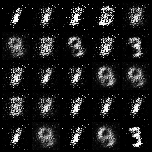

In [9]:
from IPython.display import Image, display
import os

image_path = "generated_images/epoch_20.png"

display(Image(filename=image_path))
